## If you are running container on machine with GPU 

In [ ]:
!pip install --no-cache-dir http://download.pytorch.org/whl/cu80/torch-0.1.12.post2-cp27-none-linux_x86_64.whl

## Otherwise install CPU version

In [ ]:
! pip install --no-cache-dir http://download.pytorch.org/whl/cu75/torch-0.1.12.post2-cp27-none-linux_x86_64.whl

## Install torchvision & download CRNN model ( for both CPU & GPU)

In [1]:
!pip install --upgrade torchvision
!wget https://www.dropbox.com/s/l0vo83hmvv2aipn/crnn.pth

Requirement already up-to-date: torchvision in /usr/local/lib/python2.7/dist-packages
    100% |################################| 16.9MB 61kB/s  eta 0:00:01
Requirement already up-to-date: six in /usr/local/lib/python2.7/dist-packages (from torchvision)
Requirement already up-to-date: torch in /usr/local/lib/python2.7/dist-packages (from torchvision)
    100% |################################| 5.9MB 186kB/s eta 0:00:01
Requirement already up-to-date: pyyaml in /usr/local/lib/python2.7/dist-packages (from torch->torchvision)
  Found existing installation: numpy 1.13.3
    Uninstalling numpy-1.13.3:
      Successfully uninstalled numpy-1.13.3
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0
--2018-01-21 19:04:21--  https://www.dropbox.com/s/l0vo83hmvv2aipn/crnn.pth
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.1, 2620:100:6019:1::a27d:401
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.1|:443... co

In [2]:
import sys
sys.path.append('../../../server')

In [3]:
import dvalib.crnn.utils as utils 
import dvalib.crnn.dataset as dataset
import torch
from torch.autograd import Variable
from PIL import Image
import dvalib.crnn.models.crnn as crnn
import glob
from IPython.core import display


model_path = 'crnn.pth'
alphabet = '0123456789abcdefghijklmnopqrstuvwxyz'
model = crnn.CRNN(32, 1, 37, 256, 1)
print('loading pretrained model from %s' % model_path)
model.load_state_dict(torch.load(model_path))
converter = utils.strLabelConverter(alphabet)
transformer = dataset.resizeNormalize((100, 32))

loading pretrained model from crnn.pth


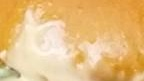

p-------a----------------- => pa                  


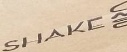

s----p----a---k---e----s-- => spakes              


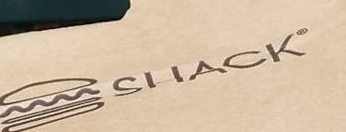

s---e----e-l---a-c--k--s-- => seelacks            


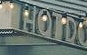

t------h----o-------d--s-- => thods               


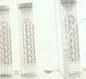

ii--------r-----a--------- => ira                 


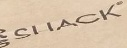

s--s---n----a---c---k----- => ssnack              


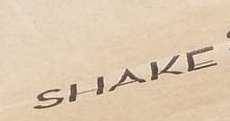

s-------t----a---k---e---- => stake               


a-------------n---e--s-s-- => aness               


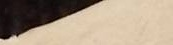

i--------------------n---- => in                  


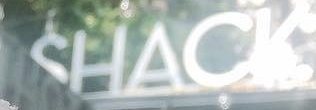

s-----h-----a---c---kk---- => shack               


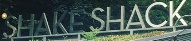

ss-h-a--k-e-ssh--aa-c--k-- => shakeshack          


s---------------e-n----s-- => sens                


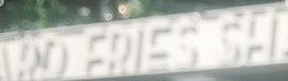

p----t-e--r--e--a--t-l---- => ptereatl            


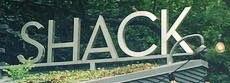

ss----h---a---c---k------- => shack               


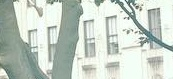

p------f-----g--e--------- => pfge                


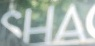

s-------h--------a-------- => sha                 


f--o--o-d---ss-c-ra--p--s- => foodscraps          


e--x--e-r--e--g--a--t--e-- => exeregate           


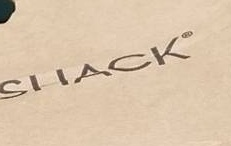

d-----r--r--c----v-----d-- => drrcvd              


In [4]:
for img_path in glob.glob('boxes/*.jpg'):
    image = Image.open(img_path).convert('L')
    image = transformer(image)
    image = image.view(1, *image.size())
    image = Variable(image)
    model.eval()
    preds = model(image)
    _, preds = preds.max(2)
    preds = preds.squeeze(2)
    preds = preds.transpose(1, 0).contiguous().view(-1)
    preds_size = Variable(torch.IntTensor([preds.size(0)]))
    raw_pred = converter.decode(preds.data, preds_size.data, raw=True)
    sim_pred = converter.decode(preds.data, preds_size.data, raw=False)
    display.display(display.Image(img_path))
    print('%-20s => %-20s' % (raw_pred, sim_pred))